Using device: cuda:1
Epoch   0 | Loss: 0.3012 | Accuracy: 0.8825
Epoch  50 | Loss: 0.6517 | Accuracy: 0.8200
Epoch 100 | Loss: 0.8089 | Accuracy: 0.7885
Epoch 150 | Loss: 0.6516 | Accuracy: 0.8570
Epoch 200 | Loss: 0.6845 | Accuracy: 0.8545
Epoch 250 | Loss: 0.7839 | Accuracy: 0.8190
Epoch 300 | Loss: 0.7670 | Accuracy: 0.8175
Epoch 350 | Loss: 0.7044 | Accuracy: 0.8735
Epoch 400 | Loss: 0.7345 | Accuracy: 0.8540
Epoch 450 | Loss: 1.0046 | Accuracy: 0.8225
Epoch 500 | Loss: 0.9041 | Accuracy: 0.8305
Epoch 550 | Loss: 1.0319 | Accuracy: 0.8730
Epoch 600 | Loss: 0.8920 | Accuracy: 0.8525
Epoch 650 | Loss: 0.8482 | Accuracy: 0.8410
Epoch 700 | Loss: 0.8695 | Accuracy: 0.8395
Epoch 750 | Loss: 0.8746 | Accuracy: 0.8535
Epoch 800 | Loss: 0.7751 | Accuracy: 0.8675
Epoch 850 | Loss: 0.8495 | Accuracy: 0.8525
Epoch 900 | Loss: 0.7221 | Accuracy: 0.8510
Epoch 950 | Loss: 0.8518 | Accuracy: 0.8675
Epoch 1000 | Loss: 1.0252 | Accuracy: 0.8125
Epoch 1050 | Loss: 0.9060 | Accuracy: 0.8385
Epoch 110

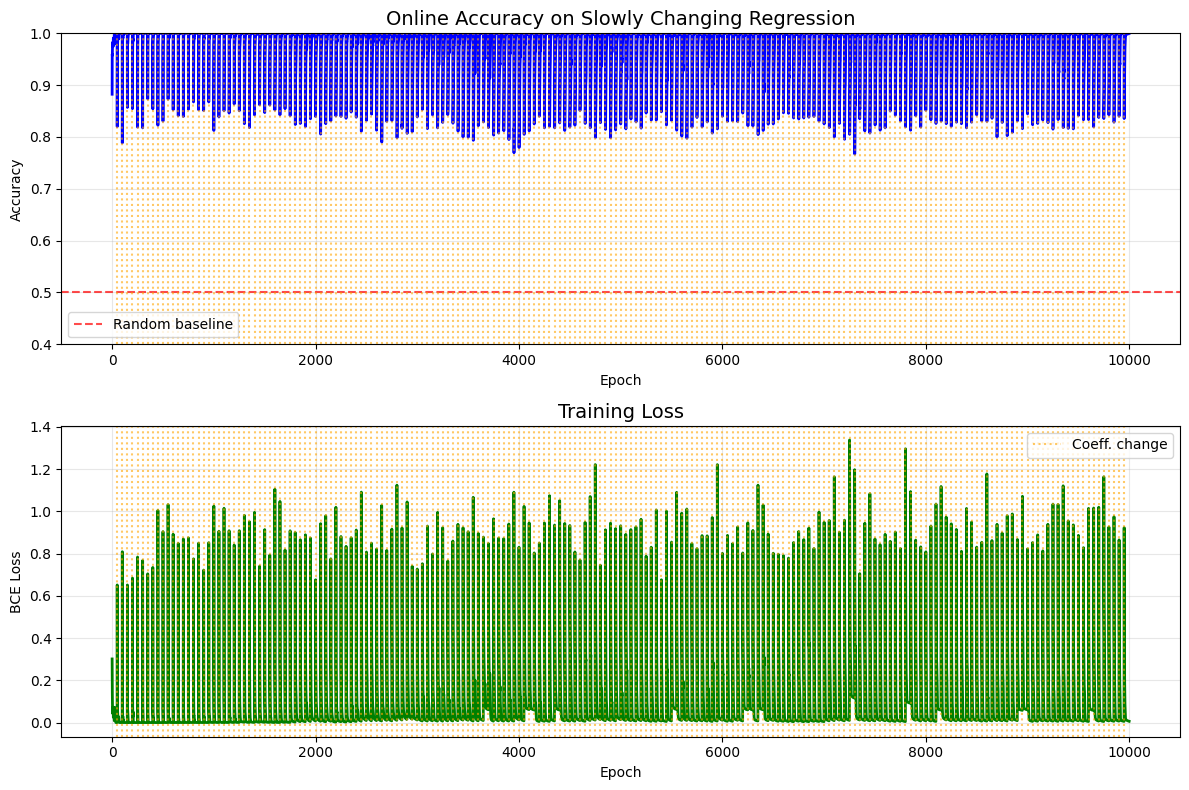


Final accuracy: 1.0000
Average accuracy: 0.9777
Accuracy std: 0.0451


In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters
input_dim = 20
hidden_dim = 500
n_samples = 2000
batch_size = 128
n_epochs = 10000
w_change_freq = 50  # change w every 25 epochs
rotation_angle = 0.5  # rotation amount in radians

# Initialize true coefficients w on unit sphere
w_true = torch.randn(input_dim, device=device)
w_true = w_true / w_true.norm()

# Simple MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

model = MLP(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.BCELoss()

# Generate fixed x data
x_data = torch.randn(n_samples, input_dim, device=device)

accuracies = []
losses = []

for epoch in range(n_epochs):
    # Rotate w_true on sphere every w_change_freq epochs
    if epoch % w_change_freq == 0 and epoch > 0:
        # Random direction orthogonal to current w_true
        rand_dir = torch.randn(input_dim, device=device)
        rand_dir = rand_dir - (rand_dir @ w_true) * w_true  # orthogonalize
        rand_dir = rand_dir / rand_dir.norm()  # normalize
        
        # Rotate w_true
        cos_angle = torch.cos(torch.tensor(rotation_angle, device=device))
        sin_angle = torch.sin(torch.tensor(rotation_angle, device=device))
        w_true = cos_angle * w_true + sin_angle * rand_dir
    
    # Generate binary labels from logistic regression
    logits = x_data @ w_true
    y_probs = torch.sigmoid(logits)
    y_labels = (y_probs > 0.5).float()
    
    # Training loop
    model.train()
    epoch_loss = 0
    correct = 0
    
    for i in range(0, n_samples, batch_size):
        batch_x = x_data[i:i+batch_size]
        batch_y = y_labels[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == batch_y).sum().item()
    
    accuracy = correct / n_samples
    avg_loss = epoch_loss / (n_samples // batch_size)
    
    accuracies.append(accuracy)
    losses.append(avg_loss)
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}')

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Accuracy plot
ax1.plot(accuracies, 'b-', linewidth=2)
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Random baseline')
for i in range(w_change_freq, n_epochs, w_change_freq):
    ax1.axvline(x=i, color='orange', linestyle=':', alpha=0.6)
ax1.set_title('Online Accuracy on Slowly Changing Regression', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(0.4, 1.0)

# Loss plot
ax2.plot(losses, 'g-', linewidth=2)
for i in range(w_change_freq, n_epochs, w_change_freq):
    ax2.axvline(x=i, color='orange', linestyle=':', alpha=0.6, label='Coeff. change' if i == w_change_freq else '')
ax2.set_title('Training Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BCE Loss')
ax2.grid(True, alpha=0.3)
if w_change_freq < n_epochs:
    ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nFinal accuracy: {accuracies[-1]:.4f}")
print(f"Average accuracy: {np.mean(accuracies):.4f}")
print(f"Accuracy std: {np.std(accuracies):.4f}")